# Notebook #1: Neural Architecture Search and Pruning



In this notebook, you will:
1. Import a simple dataset for image classification (CIFAR 10)
2. Build a "SuperNet" and train it, initially without searching for an optimal path
3. Run the actual NAS loop to identify paths that yield good trade-offs between accuracy and network cost.
4. Export an optimized architecture from the SuperNet and fine-tune it.
5. Apply structured pruning with the PIT algorithm "on top" of this optimized DNN
6. Export and optionally fine-tune the pruned model.

Considering the flow seen in class, we are here:

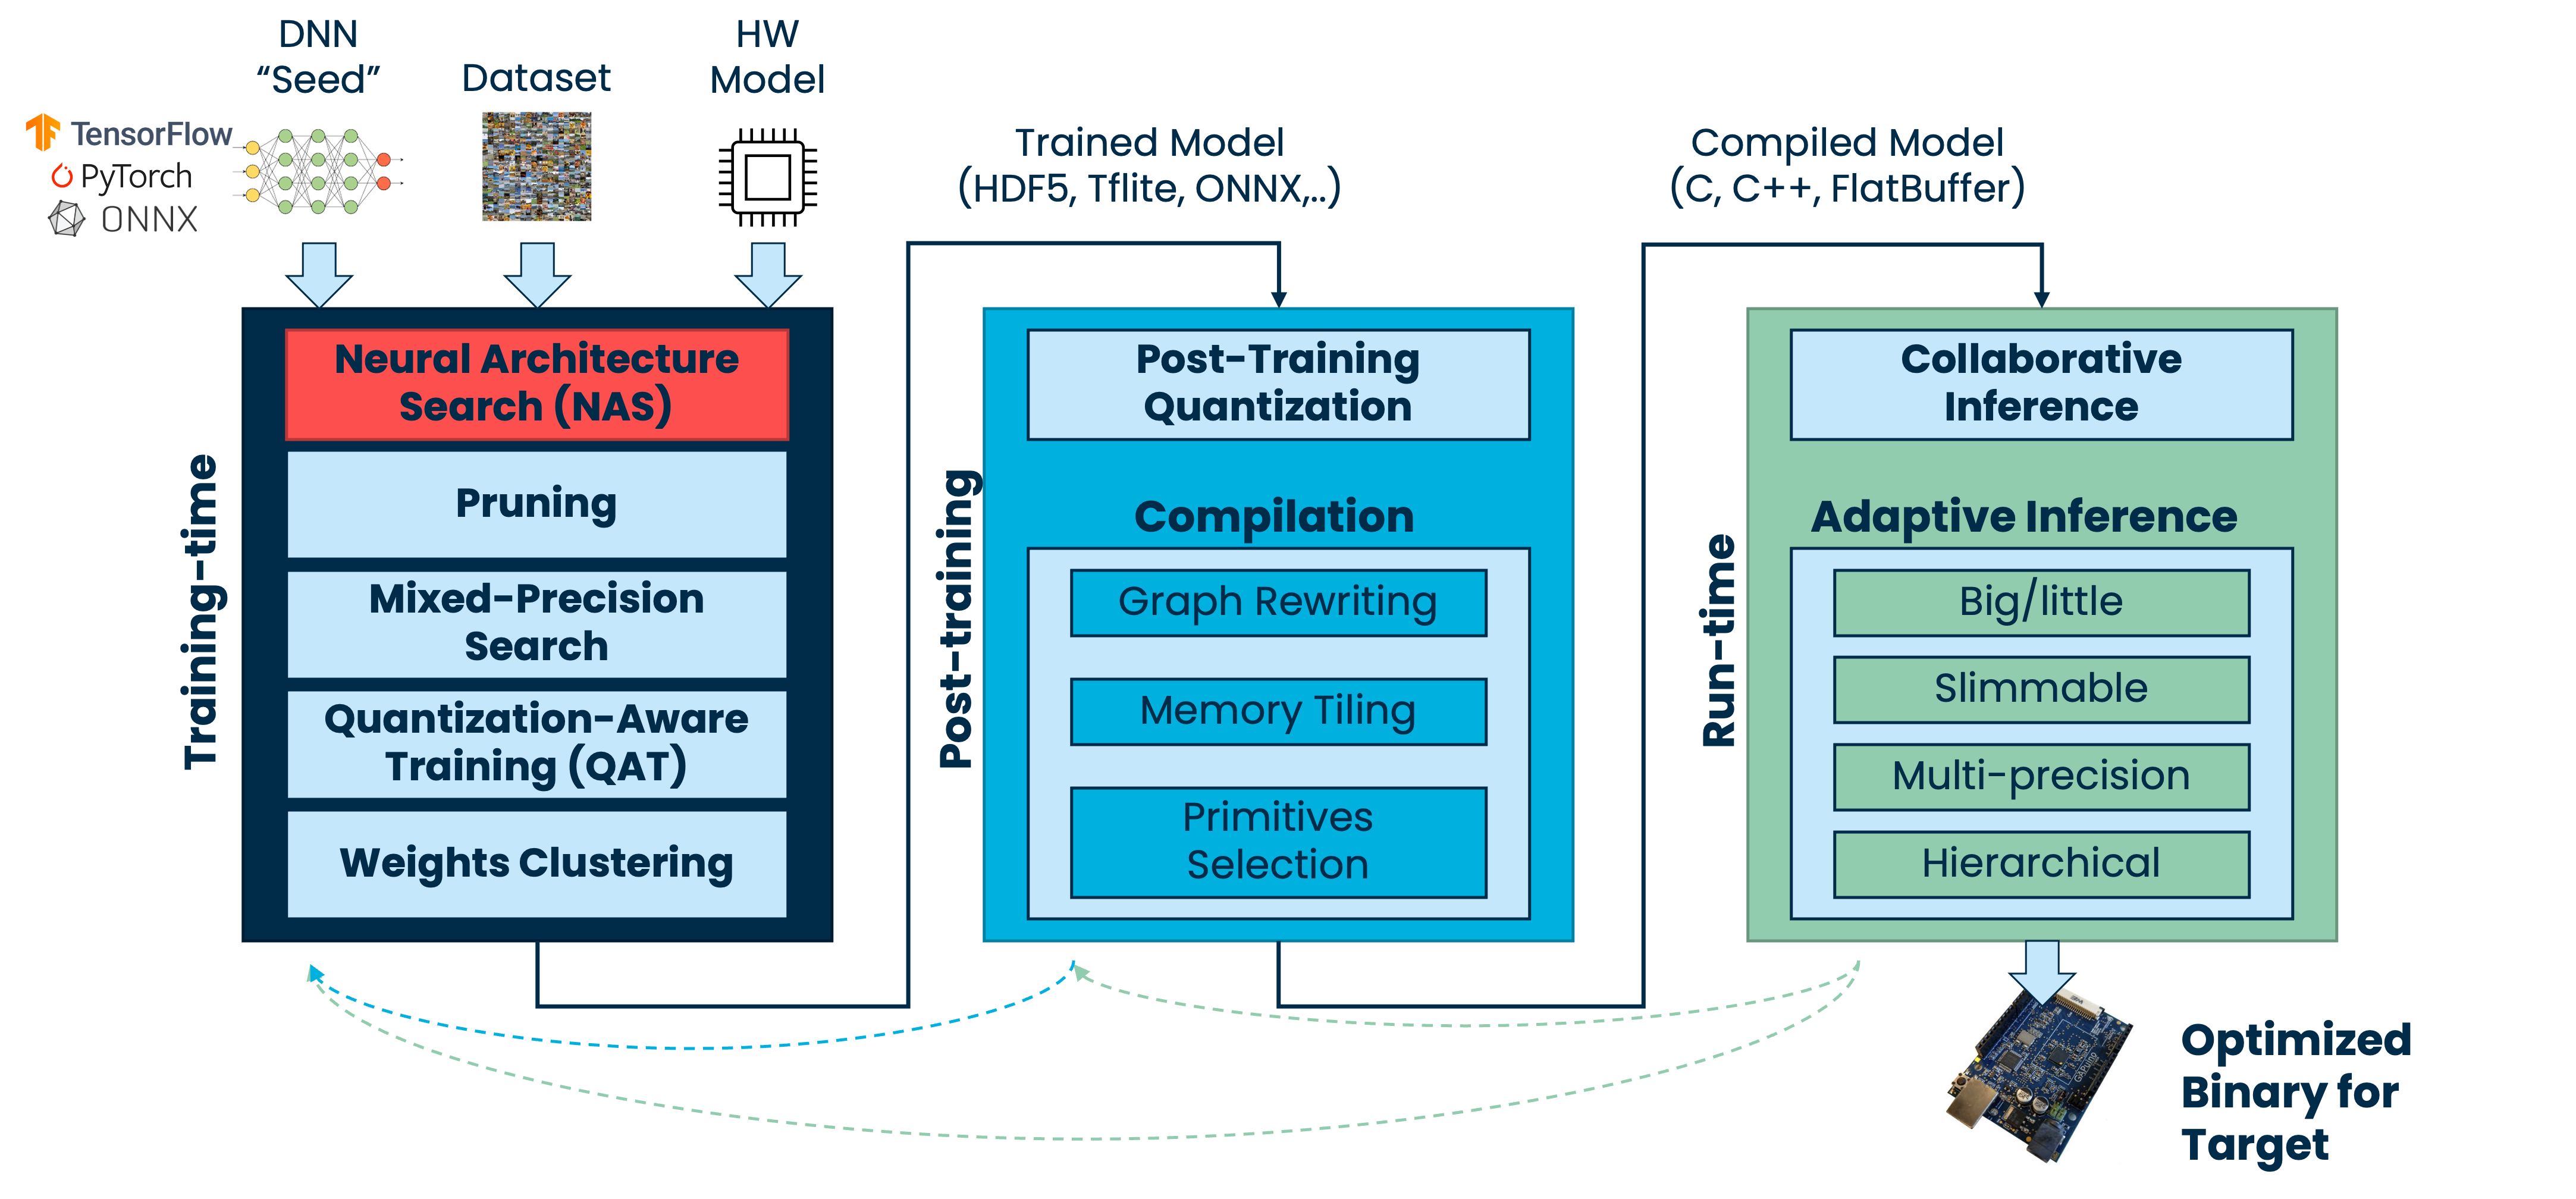


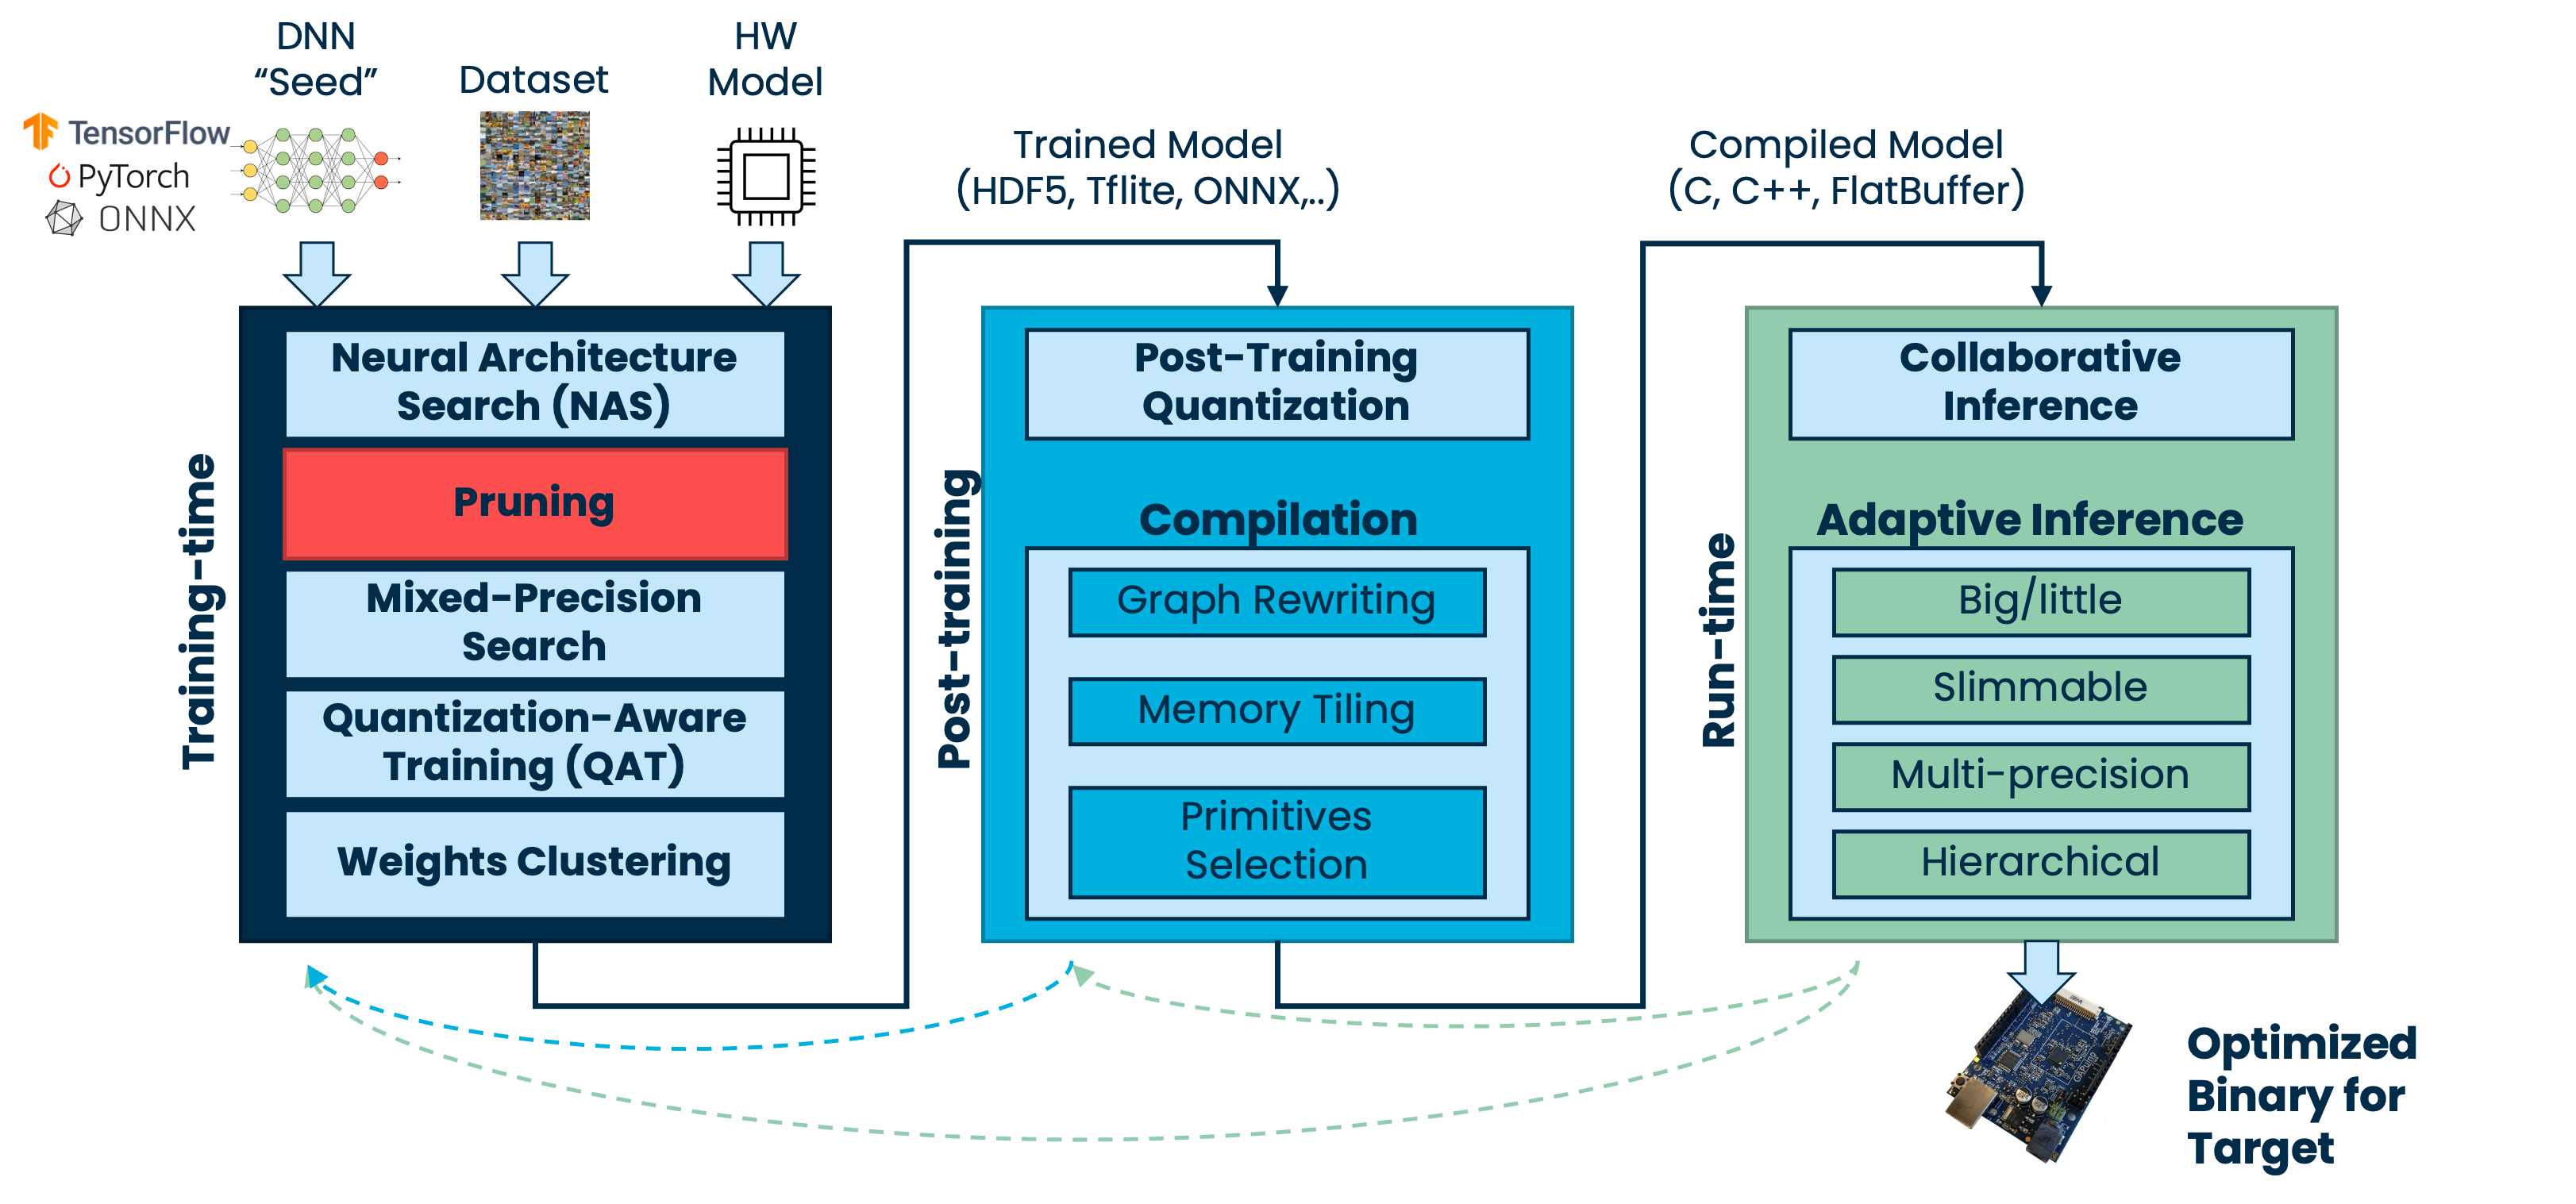

# Part 0: Initial Setup

In [2]:
import os
import sys
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchinfo import summary

from plinio.cost import params
from plinio.methods import SuperNet
from plinio.methods.supernet import SuperNetModule

import pytorch_benchmarks.image_classification as icl
from pytorch_benchmarks.utils import CheckPoint, EarlyStopping

from utils.train import set_seed, try_load_checkpoint
from utils.plot import plot_learning_curves, plot_learning_curves_nas

Next, we perform some initial setup operations. Namely, we set some constants for file paths and define `TRAINING_CONFIG`, a dictionary containing basic training configurations, which we'll use later. Lastly, we set the training device (GPU if available, CPU otherwise).

In [3]:
SAVE_DIR = Path(f"checkpoints/01/")

TRAINING_CONFIG = {
    'in_class': True,           # set this to true to skip or shorter some trainings and speed-up the execution
    'epochs': 500,              # max epochs for normal trainings
    'nas_epochs': 100,          # max epochs for the NAS search loop
    'nas_no_stop_epochs': 20,   # initial epochs without early stopping for the NAS
    'batch_size': 32,           # batch size
    'lr': 0.1,                  # initial learning rate for normal DNN parameters during warmup
    'search_lr_net': 0.001,     # learning rate for DNN weights during NAS
    'search_lr_nas': 0.0005,    # learning rate for NAS parameters during NAS
    'weight_decay': 1e-4,       # weight decay for normal DNN parameters
    'patience': 50,             # early-stopping patience for normal trainings
    'nas_patience': 20,         # early-stopping patience for NAS search
}

set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Working on: {device}")

Working on: cpu


# Part 1: Dataset Preparation

Let's start by downloading and preparing a dataset on which we will run our optimization. As an example, we will consider CIFAR10, which contains 60,000 color images belonging to 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images.

Using the `icl` sub-package included in our benchmarks library, we can easily get the CIFAR10 data (`get_data` function) and create training, validation and test dataloaders (`build_dataloaders`). The next cell does that. The first time that you run `get_data`, the dataset will be downloaded under the `icl_data/` folder. Subsequent invocations will reuse the already downloaded dataset:

In [4]:
datasets = icl.get_data()
dataloaders = icl.build_dataloaders(datasets, batch_size=TRAINING_CONFIG['batch_size'])
train_dl, val_dl, test_dl = dataloaders

Files already downloaded and verified
Files already downloaded and verified


To verify that the dataset has been retrieved correctly, let's visualize the first 25 images from the training set and display the corresponding class names:

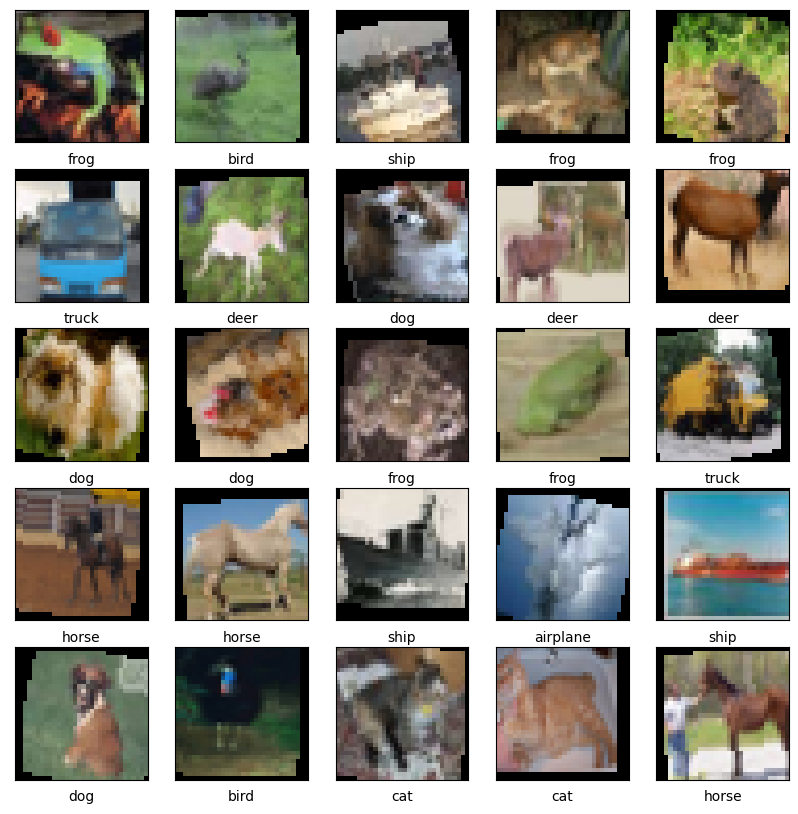

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(datasets[0][i][0].permute(1,2,0))
    # The CIFAR labels happen to be arrays, which is why you need the extra index
    plt.xlabel(class_names[datasets[0][i][1]])
plt.show()

# Part 2: PLiNIO Introduction

For the following parts of this notebook and the following two, we will use an open-source DNN optimization library called **PLiNIO** (**P**lug-and-Play **Li**ghtweight **N**eural **I**nference **O**ptimization), that we developed internally at Politecnico di Torino. You can find PLiNIO's code and documentation at [this](https://github.com/eml-eda/plinio) link.

![plinio.png]( 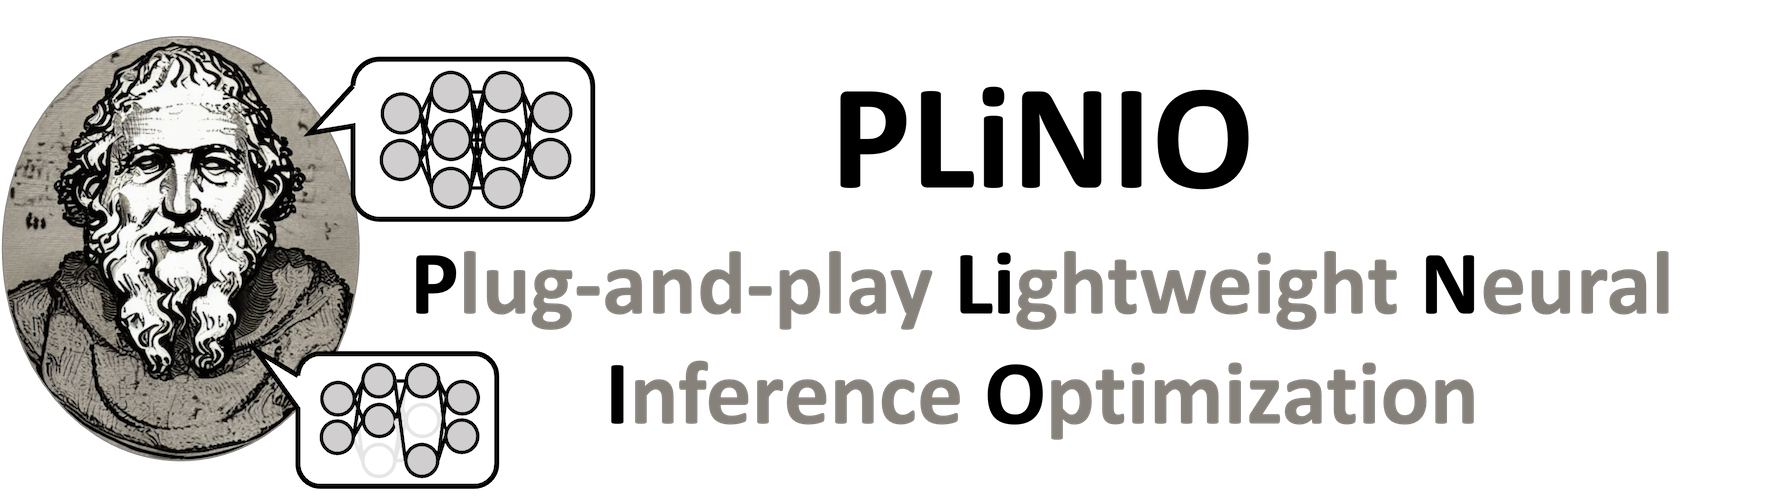)

Of course, there are many alternatives to this library, some much more complete and capable. Examples include Microsoft's [NNI](https://github.com/microsoft/nni) or Freiburg's [NASLib](https://github.com/automl/NASLib). We use PLiNIO for the following reasons:
- It was designed with usability in mind, and requires miminal modifications to your existing pytorch training code, which is good for time-constrained sessions like ours.
- As we will see later, PLiNIO can export ONNX files in the format expected by our DNN compiler (MATCH) and target hardware (GAP8).
- We developed the library internally, so we should be able to solve issues if they occur (hopefully....)

As you can read in the documentation, PLiNIO supports multiple types of optimization, with a common API. In general, optimizing a model with PLiNIO requires three basic steps.

- Converting a PyTorch model (an `nn.Module` instance), possibly including some "special layers" and optionally pre-trained, into an "optimizable" format
- Training the converted model, with a modified loss function that considers both the model's accuracy and its cost (e.g. in terms of number of parameters).
- Exporting the final output of the optimization, back to a standard PyTorch `nn.Module` format.


# Part 3: SuperNet-based DNAS

When looking for an accurate yet efficient DNN for a certain task, the first step usually consists in finding a good architecture for it. We will implement this step using the **SuperNet** method, seen in class, and included among the optimizations supported by PLiNIO. Namely, we will construct a multi-path DNN with trainable parameters associated to each layer choice, and use gradient descent to "learn" the best combination of layers for a given accuracy versus cost trade-off.

## SuperNet Creation

The SuperNet that we are going to create includes **5 blocks**, each with 3 possible alternatives (3x3 convolution, 5x5 convolution, and 3x3 separable convolution). Each block doubles the number of output channels with respect to the previous one, and most of them are followed by a MaxPooling layer. Lastly, a single linear layer produces the output scores for each class.

Note that this architecture, which is inspired by classic LeNet-like CNNs, is *far from being* state-of-the-art for this task (e.g., it does not use residual connections). We also do not use advanced training techniques such as dropout, data augmentation, etc. This simple setup works well-enough here for teaching purposes, but of course the same flow could be applied to more advanced models too.


### Model Class Definition

Let's define the SuperNet class. This will be a normal PyTorch `nn.Module` sub-class, which we'll later pass through a conversion step using PLiNIO to make it "optimizable".

We split the definition in two parts. First, we define a `ConvBlock` class for each single composing block of the DNN. Then, we use multiple instances of this class to construct  the main DNN `TutorialModel`. The `ConvBlock` class internally uses `SuperNetModule` a class defined in PLiNIO to ease the definition of multi-path SuperNets. Essentially, each `SuperNetModule` expects a list of `nn.Module` instances as parameters. Each element of this list will be one of the alternatives considered during the DNAS. In our case, as anticipated, we select between:
- A standard 3x3 convolution
- A standard 5x5 convolution
- A separable 3x3 convolution (composed of DepthWise and PointWise layers).

Each alternative has its own batch normalization layer and ReLU activation. The last two parameters of the `SuperNetModule` constructor (`gumbel_softmax` and `hard_softmax`) configure the type of optimization performed during DNAS. If you're interested, check out the PLiNIO library for details.

In [6]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, padding=1):
        super().__init__()
        self.conv1 = SuperNetModule([
            nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=1, bias=False),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU()),
            nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 5, padding=2, stride=1, bias=False),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU()),
            nn.Sequential(
                torch.nn.Conv2d(in_channels, in_channels, 3, groups=in_channels, padding=1, stride=1, bias=False),
                torch.nn.BatchNorm2d(in_channels),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels, out_channels, 1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU()
            )], gumbel_softmax = True, hard_softmax = True)

    def forward(self, input):
        x = self.conv1(input)
        return x

class TutorialModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ch = [16, 32, 64, 128, 256]
        self.block1 = ConvBlock(3, ch[0])
        self.maxpool1 = torch.nn.MaxPool2d(2, stride = 2)
        self.block2 = ConvBlock(ch[0], ch[1])
        self.maxpool2 = torch.nn.MaxPool2d(2, stride = 2)
        self.block3 = ConvBlock(ch[1], ch[2])
        self.maxpool3 = torch.nn.MaxPool2d(2, stride = 2)
        self.block4 = ConvBlock(ch[2], ch[3])
        self.block5 = ConvBlock(ch[3], ch[4])
        self.maxpool5 = torch.nn.MaxPool2d(4, stride = 4)
        self.out = nn.Linear(256, 10)

    def forward(self, input):
        # Input layer
        x = self.block1(input)
        x = self.maxpool1(x)
        x = self.block2(x)
        x = self.maxpool2(x)
        x = self.block3(x)
        x = self.maxpool3(x)
        x = self.block4(x)
        # no max-pool here
        x = self.block5(x)
        x = self.maxpool5(x)
        x = torch.flatten(x, 1)
        x = self.out(x)

        return x

Next, we create an instance of this DNN and move it to our training device. Then, we show its architecture using `torchinfo`:

In [7]:
model = TutorialModel()
model = model.to(device)

# compute the shape of a single input, and of a one-input minibatch
input_shape = datasets[0][0][0].numpy().shape
batch_shape = (1,) + input_shape
# show the network summary
print(summary(model, batch_shape, depth=5))

Layer (type:depth-idx)                        Output Shape              Param #
TutorialModel                                 [1, 10]                   --
├─ConvBlock: 1-1                              [1, 16, 32, 32]           --
│    └─SuperNetModule: 2-1                    [1, 16, 32, 32]           --
│    │    └─ModuleList: 3-1                   --                        --
│    │    │    └─Sequential: 4-1              [1, 16, 32, 32]           --
│    │    │    │    └─Conv2d: 5-1             [1, 16, 32, 32]           432
│    │    │    │    └─BatchNorm2d: 5-2        [1, 16, 32, 32]           32
│    │    │    │    └─ReLU: 5-3               [1, 16, 32, 32]           --
│    │    │    └─Sequential: 4-2              [1, 16, 32, 32]           --
│    │    │    │    └─Conv2d: 5-4             [1, 16, 32, 32]           1,200
│    │    │    │    └─BatchNorm2d: 5-5        [1, 16, 32, 32]           32
│    │    │    │    └─ReLU: 5-6               [1, 16, 32, 32]           --
│    │    │    └

As you can see, the complete SuperNet, including all possible layer alternatives, has **1.53M** parameters. However, remember that we will only select a *single path* from this network.

## Initial SuperNet Training (Warm-Up)

We will now start to train the multi-path SuperNet. In the first phase of this training, we will only modify the **normal weights** and not the path-selection NAS parameters. This "warmup" is important to ensure that all layers are well trained, which in turn helps the following NAS search to converge to good solutions. During this initial training, a **different path will be randomly sampled** in each iteration, ensuring that all layer alternatives receive an equal amount of training.

To train our model, we use the following setup:

- As **loss** function, we use the standard multi-class cross entropy.
- We use a basic SGD **optimizer** with weight decay
- We use a cosine **scheduling** for the learning rate
- We save periodic **checkpoints** of our model monitoring the validation set accuracy
- We **early-stop** the training if the validation accuracy does not improve for a certain number of epochs (set with the 'patience' parameter).

For the first three settings, we make use of standard PyTorch classes, while the last two are implemented with utility classes defined in our `pytorch_benchmarks` library.

The next cell defines the training loop, wrapping it in a function for later reuse.
It makes use of a pre-cooked `train_one_epoch` function from our benchmark library. The content of this function is pretty basic: it trains the model for one epoch, implementing the usual iteration over minibatches, with forward and backward steps, followed by weight updates. Checkout the library code if interested.


At the end of training, the best model is loaded from the corresponding checkpoint, and also re-saved as `best.ckp` for later retrieval. Indeed, you can see that the function is written so that training is entirely skipped if `best.ckp` is found in the target folder.

**NOTE**: Since this part is not particularly interesting, and also takes a *lot* of time (since the random sampling of paths makes training slower) during our in-class session, we will skip it, and directly load a pre-cooked checkpoint provided with the repo.

In [8]:
def training_loop(out_dir, config, model, criterion, train_dl, val_dl, device):

    # in this case, we use a pre-cooked checkpoint provided with the repo.
    if config['in_class']:
        out_dir = Path(str(out_dir).replace('experiments', 'checkpoints'))
    # look for a "best.ckp" within "out_dir" and skip the training if found
    if try_load_checkpoint(model, out_dir, device) or config['in_class']:
        print(f"Skipping training and loading pre-cooked model from: {out_dir}")
        with open(out_dir / 'history.pkl', 'rb') as f:
            history = pickle.load(f)
        return history

    history = []
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    checkpoint = CheckPoint(out_dir, model, optimizer, 'max', fmt='ck_{epoch:03d}.ckp')
    earlystop = EarlyStopping(patience=config['patience'], mode='max')
    
    for epoch in range(config['epochs']):
        metrics = icl.train_one_epoch(epoch, model, criterion, optimizer, train_dl, val_dl, device)
        history.append(metrics)
        scheduler.step()
        checkpoint(epoch, metrics['val_acc'])
        if earlystop(metrics['val_acc']):
            print("Stopped at epoch {} because of early stopping".format(epoch + 1))
            break
    # restore the best model from the checkpoint and save it again as 'best.ckp' for later retrieval.
    checkpoint.load_best()
    checkpoint.save(out_dir / 'best.ckp')
    # also save the history
    with open(out_dir / 'history.pkl', 'wb') as f:
        pickle.dump(history, f)

    return history

Call the function to start training:

In [9]:
criterion = nn.CrossEntropyLoss()
history = training_loop(SAVE_DIR / 'warmup', TRAINING_CONFIG, model, criterion, train_dl, val_dl, device)

Skipping training and loading pre-cooked model from: checkpoints/01/warmup


### Evaluating the Warmed Up SuperNet

The history data structure returned by the training loop can be used to plot learning curves:

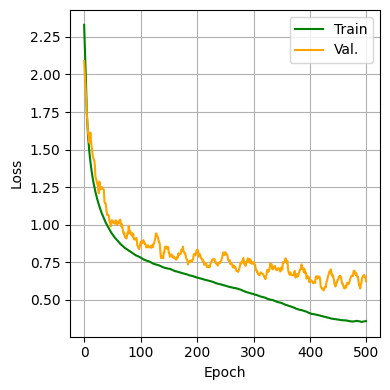

In [10]:
plot_learning_curves(history)

Let's also look at the accuracy of the warmed-up SuperNet on the test set before applying the NAS.

In [11]:
test_metrics = icl.evaluate(model, criterion, test_dl, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Test Loss: 0.46102291345596313, Test Acc: 84.80999755859375


## Prepare the SuperNet for the NAS Phase

We are now ready to run the NAS and select a single path from the SuperNet, co-optimizing accuracy and cost. To this end, the first step is to convert the model into an optimizable form. This is done with the PLiNIO class constructor `SuperNet()`. The constructor takes three main parameters:
- The previously created `nn.Module` of the SuperNet (better if already pre-trained, aka "warmed up")
- The shape of a single input sample (needed for internal graph analysis passes).
- A cost estimator, that is, the metric that we want to consider as "DNN cost". In our case, it will be the number of parameters (called `params` in PLiNIO). Other alternatives include the number of FLOPS (`ops` in PLiNIO) and hardware-dependent cost models for different hardware targets. See the library for details.

Let's implement the conversion.


In [12]:
nas_model = SuperNet(model, input_shape=input_shape, cost=params)
nas_model = nas_model.to(device)

### Getting an Initial Cost Estimate

PLiNIO optimizable models provide a `.cost` attribute that returns the current cost estimate for the model. Let's try to run it on our converted model and see what we get:

In [13]:
print(f"Estimated DNN cost: {nas_model.cost}")

Estimated DNN cost: 392112.0


**Question:** The returned cost should be around 400k parameters. Can you guess why it is much lower than the torchinfo's estimate (1.5M)?

Importantly, calling `.cost` on a PLiNIO model internally invokes a **differentiable** PyTorch function. Therefore, we can apply back-propagation to it. So, this will become our $\mathcal{L}_{cost}$ term in the loss function.

### Looking at the NAS Parameters

The following code snippet looks at the values of the $\theta$ parameters of the NAS, that influence the selection of a layer.

**Question:** did you expect these values? Why?


In [14]:
with torch.no_grad():
    for p in nas_model.nas_parameters(): 
        print(nn.functional.softmax(p, dim=0))

tensor([0.3333, 0.3333, 0.3333])
tensor([0.3333, 0.3333, 0.3333])
tensor([0.3333, 0.3333, 0.3333])
tensor([0.3333, 0.3333, 0.3333])
tensor([0.3333, 0.3333, 0.3333])


### Setting the Regularization Strength

Another key parameter to set in the loss is the regularization strength $\lambda$. Choosing a value for this scalar is difficult. However, a good rule of thumb is to consider values so that:

$$
\lambda \cdot \mathcal{L_{cost}} \simeq \mathcal{L_{task}}
$$

Since our initial cost estimate is around 400k, and the final validation loss after warmup was roughly 0.5, values around $10^{-6}$ are a good choice.
Normally, you would try different values around this range to obtain a Pareto frontier of models in the accuracy versus cost space. However,  we only have time to try a single value (per group) during this session.


**Task: please ask your instructor for the value to use, so that we can later gather results from each of you and build the Pareto frontier by merging them**

Let's add the regularization strength to our training configuration:


In [15]:
TRAINING_CONFIG['reg_strength'] = 1e-06

## Run the NAS Loop

We are now ready to run the DNAS architecture optimization loop.  For this, we will use two different optimizers for the DNN weights $W$ and for the NAS parameters $\theta$.
Part of the reason for this is that we should not apply *weight decay* to the NAS parameters. Moreover, we may also want use a different type of optimizer (e.g. SGD vs Adam) and/or learning rate for the two parameter sets.

PLiNIO offers a convenient API to get only the normal DNN weights $W$, with the `model.net_parameters()` method, or only the NAS parameters $\theta$, with `model.nas_parameters()`. We use these two methods to define a function that returns two optimizer instances, one for the weights and one for the architectural parameters. We wrap the code in a function so that we can get fresh optimizers when needed:

In [16]:
def get_nas_optimizers(model, config):
  net_optimizer = torch.optim.Adam(model.net_parameters(), lr=config['search_lr_net'], weight_decay=config['weight_decay'])
  nas_optimizer = torch.optim.Adam(model.nas_parameters(), lr=config['search_lr_nas'], weight_decay=0)
  return net_optimizer, nas_optimizer

Lastly, let's define a modified training loop for the optimization. This is similar to a standard training loop, with some key differences:

- It uses the two separate optimizers for $W$ and $\theta$ just created.
- It uses a modified loss function (`nas_criterion`, defined locally) that combines the two loss terms $\mathcal{L_{task}}$ and $\mathcal{L_{cost}}$ using the regularization strength $\lambda$.
- In each epoch, we first train the $W$ on the training set, then train the $\theta$ on the **validation** set. This ensures that we select architectures that generalize well over data not included in the training set.

To make sure that the iteration on the training set only affects the $W$, and the one on the validation set only the $\theta$, we use two utility functions in PLiNIO, respectively `train_net_only()` and `train_nas_only()`. These ensure that gradients are only propagated to DNN weights and NAS parameters respectively. There is also a third method `train_net_and_nas()` to enable gradient propagation to both sets of parameters simultaneously.

In [17]:
def nas_loop(out_dir, config, model, criterion, train_dl, val_dl, device):

    if try_load_checkpoint(model, out_dir, device):
        print(f"Skipping NAS and loading pre-cooked model from: {out_dir}")
        with open(out_dir / 'history.pkl', 'rb') as f:
            history = pickle.load(f)
        return history

    history = []
    net_optimizer, nas_optimizer = get_nas_optimizers(model, config)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
    checkpoint = CheckPoint(out_dir, model, net_optimizer, 'min', fmt='ck_{epoch:03d}.ckp')
    earlystop = EarlyStopping(patience=config['nas_patience'], mode='min')

    # define the NAS loss function
    def nas_criterion(output, target):
        return criterion(output, target) + config['reg_strength'] * model.cost

    for epoch in range(config['nas_epochs']):
        model.train_net_only()
        t_metrics = icl.train_one_epoch(epoch, model, criterion, net_optimizer, train_dl, val_dl, device)
        #scheduler.step()
        model.train_nas_only()
        # note that here we train on the VALIDATION set ------------------------------*
        n_metrics = icl.train_one_epoch(epoch, model, nas_criterion, nas_optimizer, val_dl, val_dl, device)
        print(f"Network cost after epoch {epoch+1} = {model.cost}")

        # combine the metrics from the two "sub-epochs", add the cost, and append all to the history
        n_metrics = {'nas_' + k: v for k, v in n_metrics.items()}
        t_metrics.update(n_metrics)
        t_metrics['cost'] = model.cost.detach().cpu().numpy()
        history.append(t_metrics)
        
        if epoch >= config['nas_no_stop_epochs']:
            # save checkpoint and early-stop only after the first few epochs,
            # leaving time to the NAS to modify the architecture
            checkpoint(epoch, n_metrics['nas_loss'])
    
            if earlystop(n_metrics['nas_loss']):
                print("Stopped at epoch {} because of early stopping".format(epoch + 1))
                break
                
    checkpoint.load_best()
    checkpoint.save(out_dir / 'best.ckp')
    with open(out_dir / 'history.pkl', 'wb') as f:
        pickle.dump(history, f)

    return history

Run the NAS loop. You will see the accuracy drop initially, as the NAS converges to sampling always the same SuperNet path. Then, with further training, the model should recover most of the drop.

In [18]:
criterion = nn.CrossEntropyLoss()
history = nas_loop(SAVE_DIR / 'nas', TRAINING_CONFIG, nas_model, criterion, train_dl, val_dl, device)

Skipping NAS and loading pre-cooked model from: checkpoints/01/nas


Let's see what happened during this run:

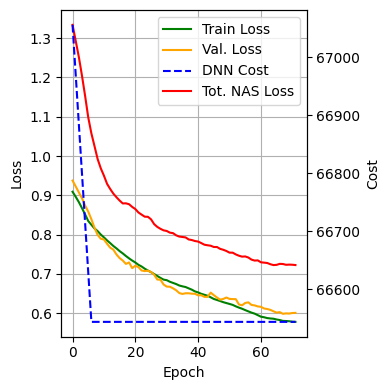

In [19]:
plot_learning_curves_nas(history)

### Evaluating the SuperNet After the Search

Let's check the test accuracy of the optimized SuperNet **after** applying the NAS.

In [20]:
test_metrics = icl.evaluate(nas_model, criterion, test_dl, device)
print(f'Final model cost: {nas_model.cost}, Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Final model cost: 66544.0, Test Loss: 0.5286077260971069, Test Acc: 81.45999908447266


You should see that, despite a significant decrease in cost, the test accuracy is well preserved (possibly with a drop of a few percentage points).

### Looking at the NAS Parameters (After the Search)

**Question:** Let's look again at the $\theta$ parameters. Have they changed? How?


In [21]:
with torch.no_grad():
    for p in nas_model.nas_parameters(): 
        print(nn.functional.softmax(p, dim=0))

tensor([0.7119, 0.2765, 0.0116])
tensor([0.7564, 0.1460, 0.0976])
tensor([0.9083, 0.0107, 0.0810])
tensor([0.0090, 0.0011, 0.9899])
tensor([1.3987e-04, 4.5495e-05, 9.9981e-01])


## Final Model Export and Optional Fine-Tuning

This model is still an instance of the `SuperNet` class. In order to obtain a standard `nn.Module` that we can use with any other torch-based tool (such as `torchinfo`), we can leverage  the `model.export()` API of PLiNIO.

In [22]:
final_model = nas_model.export()
final_model = final_model.to(device)

Let's look at the architecture of the optimized model using `torchinfo`.

In [23]:
print(summary(final_model, batch_shape, depth=5))

Layer (type:depth-idx)                        Output Shape              Param #
TutorialModel                                 [1, 10]                   --
├─Module: 1-1                                 --                        --
│    └─Module: 2-1                            --                        --
│    │    └─Module: 3-1                       --                        --
│    │    │    └─Module: 4-1                  --                        --
│    │    │    │    └─Conv2d: 5-1             [1, 16, 32, 32]           432
│    │    │    │    └─BatchNorm2d: 5-2        [1, 16, 32, 32]           32
│    │    │    │    └─ReLU: 5-3               [1, 16, 32, 32]           --
├─MaxPool2d: 1-2                              [1, 16, 16, 16]           --
├─Module: 1-3                                 --                        --
│    └─Module: 2-2                            --                        --
│    │    └─Module: 3-2                       --                        --
│    │    │    └─Mo

Finally, let's evaluate our optimized model on the test set:

In [24]:
test_metrics = icl.evaluate(final_model, criterion, test_dl, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Test Loss: 0.5286077260971069, Test Acc: 81.45999908447266


# Part 4: Structured Pruning with PIT

In the first part, we found DNN architectures that obtain good accuracy vs model size trade-offs for CIFAR 10 (within our limited search space). Now, we want to further reduce the size of one of these models, applying structured pruning with the PIT algorithm to eliminate some of the least important channels from each layer.

## The PIT Algorithm

For 2D CNNs, PIT works essentially as a channel-based pruning algorithm, and is described in details [here](https://arxiv.org/abs/2301.10281). During training, it learns to mask out unimportant channels for each layer, effectively eliminating them from the network. The working principle is schematized in the following picture:

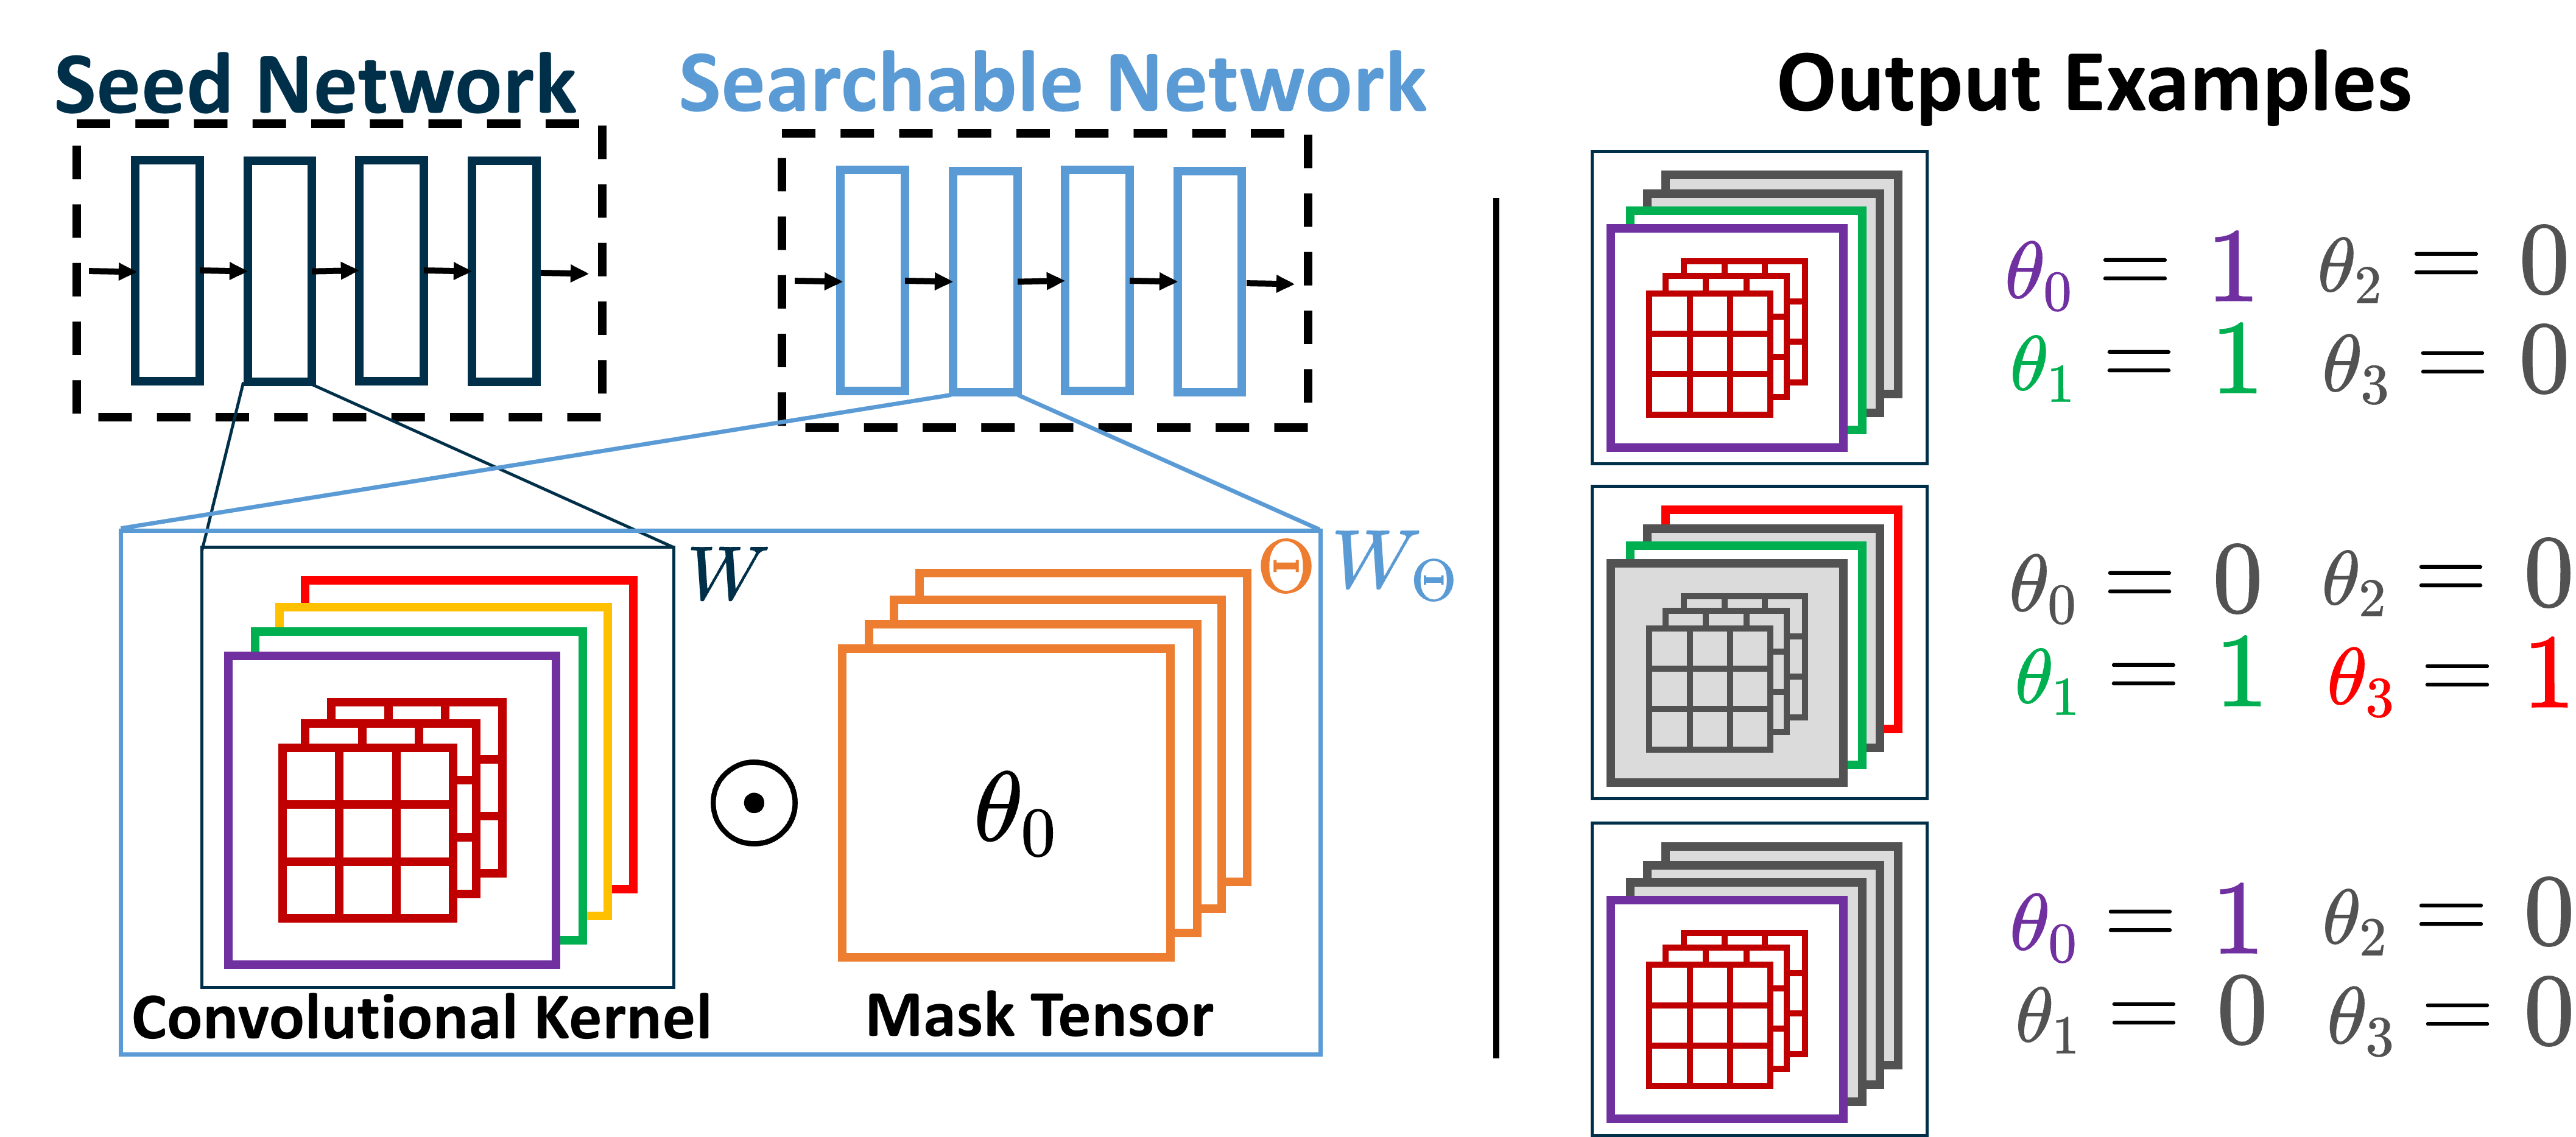

The "seed" DNN (a standard network) is turned into a "searchable" DNN by associating each supported layer (convolutional or linear) with a new set of trainable *binary* parameters $\theta$. Each $\theta_i$ is associated with a single weight filter/neuron, and functions as a mask. When it is set to $\theta_i=1$, the filter/neuron is kept, whereas, when it is set to $\theta_i =0 $ it is removed from the layer's output. Thus, the corresponding output activation channel is effectively eliminated. Notably, PIT can also optimize other parameters of 1D Convolutions (namely the kernel size and the dilation).

The $\theta$ values are trained with gradient-descent together with the normal weights of the network. In practice, what is actually trained are continuous parameters $\alpha$, from which $\theta$ binary masks are obtained through a step function ($\theta_i = \mathcal{H}(\alpha_i)$). Similarly to a SuperNet DNAS, the goal is to optimize a combined loss function in the form:

$$
\mathcal{L}_{tot}(W,\theta) = \mathcal{L}_{task}(W,\theta) + \lambda \mathcal{L}_{cost}(\theta)
$$

where $\mathcal{L}_{task}$ is the standard task-loss (cross-entropy in our case), while $\mathcal{L}_{cost}$ encodes the cost of the network. In fact, although PIT essentially implements channel pruning, it can also be considered a form of "mask-based DNAS". In the following, we will use model size (n. of parameters) as cost metric. 

## Preparing the Model

For the PIT algorithm, PLiNIO makes the optimization process much more transparent than for the SuperNet case. In fact, for the SuperNet, we had to manually define a multi-path DNN with multiple layer alternatives. In this case, instead, the input is a standard DNN (in our case, the optimized one from Hands-on #1). To make this model "optimizable", it suffices to pass it to the `PIT` class constructor from PLiNIO. The constructor internally implements the conversion steps necessary to generate the "searchable" network sketched in the figure above, replacing all Conv. and Linear layers with the respective mask-equipped versions, and handling all the necessary shape propagations to correctly estimate the DNN cost.

The parameters of the constructor are the same of SuperNet, with the addition of the optional `discrete_cost=True`, which ensures that cost is estimated using the discretized version of the masks (i.e. $\theta$, rather than $\alpha$).



### Getting an Initial Cost Estimate 
Let's call the constructor and get the initial cost estimate.

In [25]:
from plinio.methods import PIT
nas_model = PIT(final_model, input_shape=input_shape, cost=params, discrete_cost=True)
nas_model = nas_model.to(device)
print(f"Estimated DNN cost: {nas_model.cost}")

Estimated DNN cost: 69418.0


Once again, you should have a cost that is *slightly lower* than the one computed by `torchinfo`. The reason is different from the SuperNet case: here, the reduction comes from the fact that, during the conversion implemented by the PIT constructor, Batch Normalization layers are folded with convolutions (as seen in class). This is necessary for the optimization to work.
### Looking at the Pruning Masks
Similarly to the SuperNet, we can look at the initial values of the PIT pruning masks:

In [26]:
with torch.no_grad():
    for p in nas_model.nas_parameters(): 
        print((torch.abs(p)>0.5).int().cpu().numpy())

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

### Setting the Regularization Strength

Identically to the SuperNet case, we have to set the value of $\lambda$ for our combined loss function. Unfortunately, as mentioned before, there isn't a golden rule here. With the same rationale seen for the SuperNet, values around $10^{-6}$ will work fine, but some trial and error is required (or a more advanced regulatization method such as [DUCCIO](https://ieeexplore.ieee.org/abstract/document/10278089). 


In [27]:
TRAINING_CONFIG['reg_strength'] = 1e-06
SAVE_DIR = Path(f"checkpoints/02/")

## Run the NAS-PIT Loop
For running the NAS optimization, we can reuse entirely the code seen in Hands-on #1. Thanks to the convenient `ipynb` library, we can load definitions (classes, functions, etc) defined in another Jupyter notebook. Let's use this functionality to load our NAS loop from Hands-on #1. Thanks to the transparent API of PLiNIO, this code, initially written for a SuperNet optimization, will work fine also for PIT. Clearly, to obtain optimal results, one would need to tweak with the parameters, which in some cases could require some code rewriting. However, for this basic example, reusing 100\% of the NAS loop will suffice.

The next cell runs the optimization:

In [28]:
criterion = nn.CrossEntropyLoss()
history = nas_loop(SAVE_DIR / 'nas', TRAINING_CONFIG, nas_model, criterion, train_dl, val_dl, device)

Skipping NAS and loading pre-cooked model from: checkpoints/02/nas


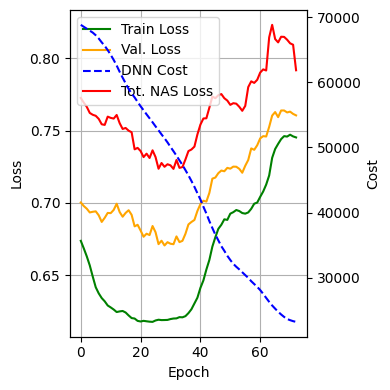

In [29]:
plot_learning_curves_nas(history)

### Evaluating the Pruned Model
Let's check the test accuracy of the pruned DNN after applying PIT.

In [30]:
test_metrics = icl.evaluate(nas_model, criterion, test_dl, device)
print(f'Final model cost: {nas_model.cost}, Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Final model cost: 55482.0, Test Loss: 0.571621835231781, Test Acc: 80.5199966430664


Depending on the regularization strength that you set, you should see that the cost (number of parameters) has reduced significantly once again, possibly at the cost of some accuracy degradation.
### Looking at the Masks (After the Search)

**Question:** Let's look again at the $\theta$ parameters. Have they changed? How? Which layers have been pruned the most? Is there one layer that *hasn't* been pruned at all? Which one and why?


In [31]:
with torch.no_grad():
    for p in nas_model.nas_parameters(): 
        print((torch.abs(p)>0.5).int().cpu().numpy())

[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
[1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1]
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1

## Final Model Export (and Fine-Tuning)

In [32]:
final_model = nas_model.export()
final_model = final_model.to(device)

In [33]:
print(summary(final_model, batch_shape, depth=5))

Layer (type:depth-idx)                        Output Shape              Param #
TutorialModel                                 [1, 10]                   --
├─Module: 1-1                                 --                        --
│    └─Module: 2-1                            --                        --
│    │    └─Module: 3-1                       --                        --
│    │    │    └─Module: 4-1                  --                        --
│    │    │    │    └─Conv2d: 5-1             [1, 15, 32, 32]           420
│    │    │    │    └─BatchNorm2d: 5-2        [1, 15, 32, 32]           30
│    │    │    │    └─ReLU: 5-3               [1, 15, 32, 32]           --
├─MaxPool2d: 1-2                              [1, 15, 16, 16]           --
├─Module: 1-3                                 --                        --
│    └─Module: 2-2                            --                        --
│    │    └─Module: 3-2                       --                        --
│    │    │    └─Mo

**Question**: Look at the exported model summary. Does the number of channels in each layer match with the mask values printed above?


In case of the PIT algorithm, fine-tuning the exported model for some epochs is *more important* than for the SuperNet. This is because, in the same way that PIT *folds* BatchNorm layers before the search, it *unfolds* them when exporting the final model, to guarantee that it has exactly the same architecture of the input (except for the pruned channels).

You can verify this by testing the model just after export. You will see the accuracy drop significantly. However, few epochs of fine-tuning should suffice to recover the drop, and possibly even improve the final accuracy (thanks to BatchNorm). Let's run them.

In [34]:
criterion = nn.CrossEntropyLoss()
history = training_loop(SAVE_DIR / 'finetune', TRAINING_CONFIG, final_model, criterion, train_dl, val_dl, device)

Skipping training and loading pre-cooked model from: checkpoints/02/finetune


In [35]:
test_metrics = icl.evaluate(final_model, criterion, test_dl, device)
print(f'Test Loss: {test_metrics["loss"]}, Test Acc: {test_metrics["acc"]}')

Test Loss: 0.46722763776779175, Test Acc: 84.25


## Saving the Final Model

Let's save the model in a separate location to reuse it more easily in later sessions:

In [36]:
torch.save(final_model, SAVE_DIR / f'final_model.pt')